In [43]:
!pip install -U --upgrade tensorflow

In [2]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
import sklearn
import tensorflow as tf
import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

In [4]:
tf.test.is_gpu_available()

True

In [ ]:
tf.__version__

In [6]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Data Visualisation

In [7]:
import os

def get_data():
    return pd.read_csv('../input/deepfake-faces/metadata.csv')


In [8]:
meta=get_data()
meta.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [9]:
meta.shape

(95634, 5)

In [10]:
# Assuming 'label' is the column containing the labels
fake_count = len(meta[meta['label'] == 'FAKE'])
real_count = len(meta[meta['label'] == 'REAL'])

print("Number of 'FAKE' labels:", fake_count)
print("Number of 'REAL' labels:", real_count)

Number of 'FAKE' labels: 79341
Number of 'REAL' labels: 16293


In [11]:
real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 8000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

As mentioned instead of using 95k images we will only use 16000 images.

In [12]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.3,random_state=42,stratify=Train_set['label'])

In [13]:
Train_set.shape,Val_set.shape,Test_set.shape

((8960, 5), (3840, 5), (3200, 5))

The original image dataset were biased with more fake images than real since we are taking a sample of it its better to take equal proportion of real and fake images.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Assuming Train_set, Val_set, and Test_set are already defined and loaded with data.

y = {0: [], 1: []}

for set_name in (np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label'])):
    y[0].append(np.sum(set_name == 'REAL'))
    y[1].append(np.sum(set_name == 'FAKE'))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='REAL',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='FAKE',
    marker=dict(color='#ff3300'),
    opacity=0.7
)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)

fig = go.Figure(data=data, layout=layout)
fig.show()


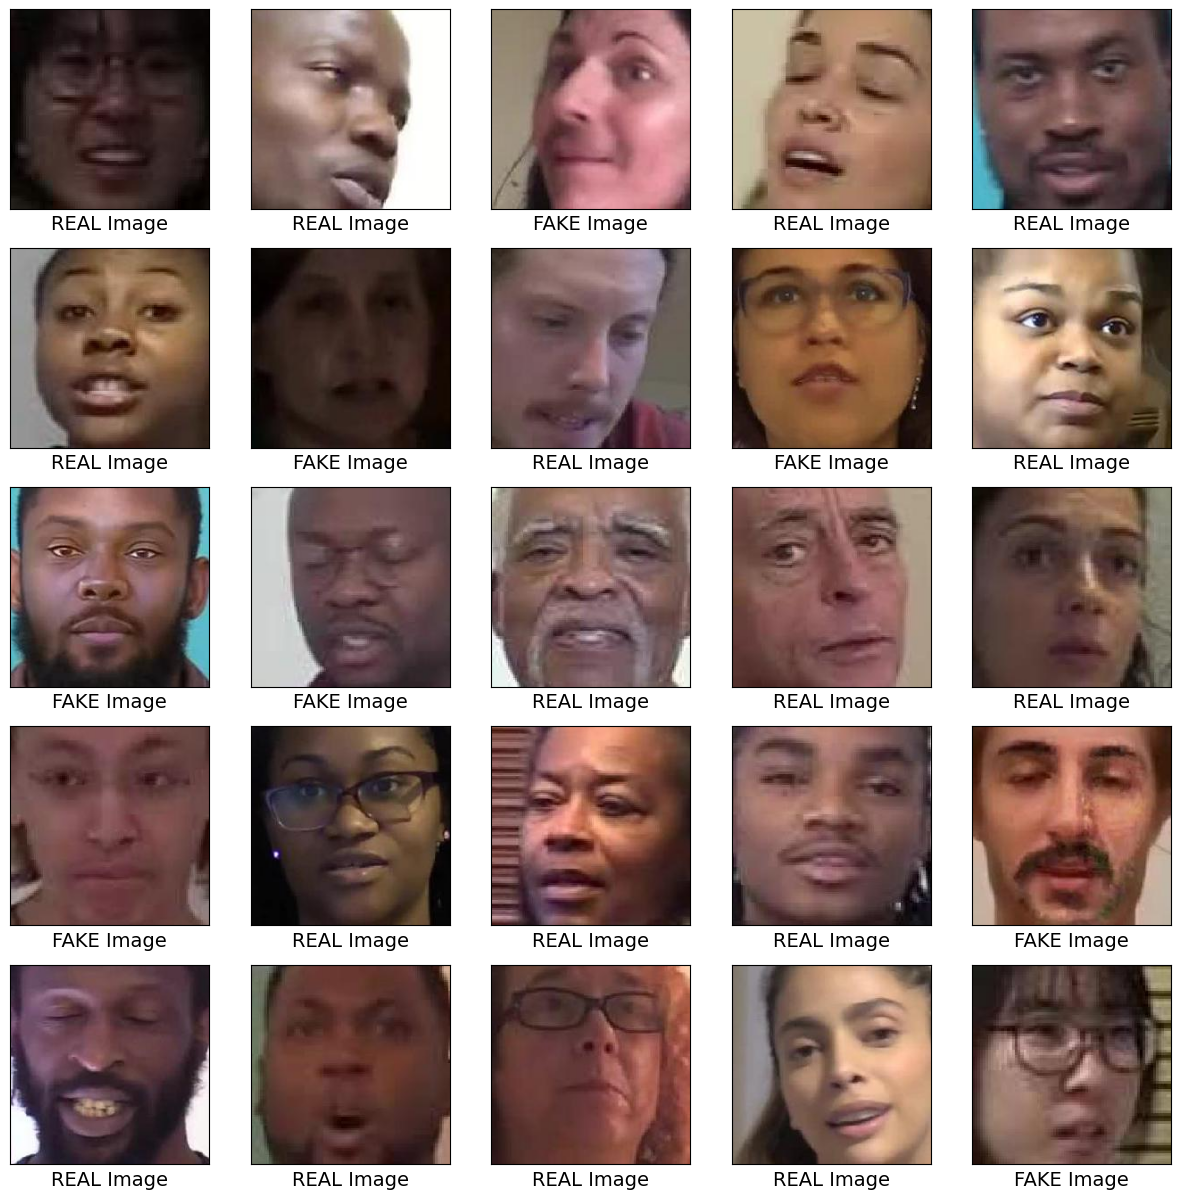

In [15]:
#Trying to display a grid of images from training set
plt.figure(figsize=(15,15))
for cur,i in enumerate(Train_set.index[25:50]):
    plt.subplot(5,5,cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    #plt.imshow(cv2.imread('../input/deepfake-faces/faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg'))
    image_path = '../input/deepfake-faces/faces_224/' + Train_set.loc[i, 'videoname'][:-4] + '.jpg'
    image = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
    if(Train_set.loc[i,'label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')

plt.show()


## Modelling

Before jumping to use pretrained model lets develop some base line model to test how our pretrained model outperforms.

In [16]:
def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('../input/deepfake-faces/faces_224/'+img[:-4]+'.jpg'))
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)

    return np.array(images),np.array(labels)

### Custom CNN Architecture

images: This list stores the loaded images. For each image filename in the dataset, it reads the corresponding image using cv2.imread, converts it to a numpy array, and appends it to the list.

labels: This list stores the corresponding labels for the images. It assigns a label of 1 (indicating 'FAKE') if the image class is 'FAKE', otherwise, it assigns a label of 0 (indicating 'REAL').

In [17]:
import cv2

def retrieve_dataset(set_name):
    images = []
    labels = []
    
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        try:
            img_path = '../input/deepfake-faces/faces_224/' + img[:-4] + '.jpg'
            image = cv2.imread(img_path)
            
            if image is not None:
                images.append(image)
                if imclass == 'FAKE':
                    labels.append(1)
                else:
                    labels.append(0)
            else:
                print(f"Unable to read image: {img_path}")
        
        except Exception as e:
            print(f"Error processing image: {img_path}. Error: {str(e)}")
    
    return images, labels

# Assuming Train_set, Val_set, and Test_set are defined elsewhere in your code
X_train, y_train = retrieve_dataset(Train_set)
X_val, y_val = retrieve_dataset(Val_set)
X_test, y_test = retrieve_dataset(Test_set)


from functools import partial

# Set random seed for reproducibility
tf.random.set_seed(42)
# Define a partial function for Conv2D layers with default parameters
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
# Create a Sequential model
model = tf.keras.Sequential([
    # Convolutional layer with 64 filters and kernel size 7x7
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    # Max pooling layer
    tf.keras.layers.MaxPool2D(),
    # Convolutional layer with 128 filters
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    # Flatten layer to convert 2D feature maps to 1D
    tf.keras.layers.Flatten(),
    # Dense (fully connected) layer with 128 units and ReLU activation
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    # Dropout layer with dropout rate 0.5 to prevent overfitting
    tf.keras.layers.Dropout(0.5),
    # Dense (fully connected) layer with 64 units and ReLU activation
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    # Output layer with 1 unit and sigmoid activation for binary classification
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

In [18]:
from functools import partial
import tensorflow as tf

# Set random seed for reproducibility
tf.random.set_seed(42)

# Define a partial function for Conv2D layers with default parameters
DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=3,
    padding="same",
    activation="relu",
    kernel_initializer="he_normal"
)

# Create the model architecture
inputs = tf.keras.Input(shape=(224, 224, 3))
x = DefaultConv2D(filters=64, kernel_size=7)(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = DefaultConv2D(filters=128)(x)
x = DefaultConv2D(filters=128)(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(units=64, activation="relu", kernel_initializer="he_normal")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [19]:
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    51,380,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,619,585 (196.91 MB)

 Trainable params: 51,619,585 (196.91 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
import numpy as np

# Ensure X_train and y_train are numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Check the shape of X_train and y_train
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Ensure X_val and y_val are numpy arrays
X_val = np.array(X_val)
y_val = np.array(y_val)

# Check the shape of X_val and y_val
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Ensure X_test and y_test are numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Check the shape of X_test and y_test
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Continue with model fitting
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

X_train shape: (8960, 224, 224, 3)
y_train shape: (8960,)
X_val shape: (3840, 224, 224, 3)
y_val shape: (3840,)
X_test shape: (3200, 224, 224, 3)
y_test shape: (3200,)
Epoch 1/5


I0000 00:00:1713949069.912644     119 service.cc:145] XLA service 0x78fc10004710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713949069.912713     119 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-04-24 08:58:01.261634: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,3,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,224,224]{3,2,1,0}, f32[64,64,224,224]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-04-24 08:58:01.484622: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.223135965s
Trying algorithm eng0{} for conv (

  1/140 ━━━━━━━━━━━━━━━━━━━━ 46:35 20s/step - accuracy: 0.5625 - loss: 104.2240

I0000 00:00:1713949087.399998     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


140/140 ━━━━━━━━━━━━━━━━━━━━ 42s 160ms/step - accuracy: 0.5094 - loss: 480.7855 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.4914 - loss: 0.6926 - val_accuracy: 0.5042 - val_loss: 0.6929
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.4976 - loss: 0.6936 - val_accuracy: 0.5010 - val_loss: 0.6933
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.5033 - loss: 0.6966 - val_accuracy: 0.4990 - val_loss: 0.6936
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.4964 - loss: 0.6946 - val_accuracy: 0.4984 - val_loss: 0.6926


In [21]:
score = model.evaluate(X_test, y_test)

100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5139 - loss: 386339.7812


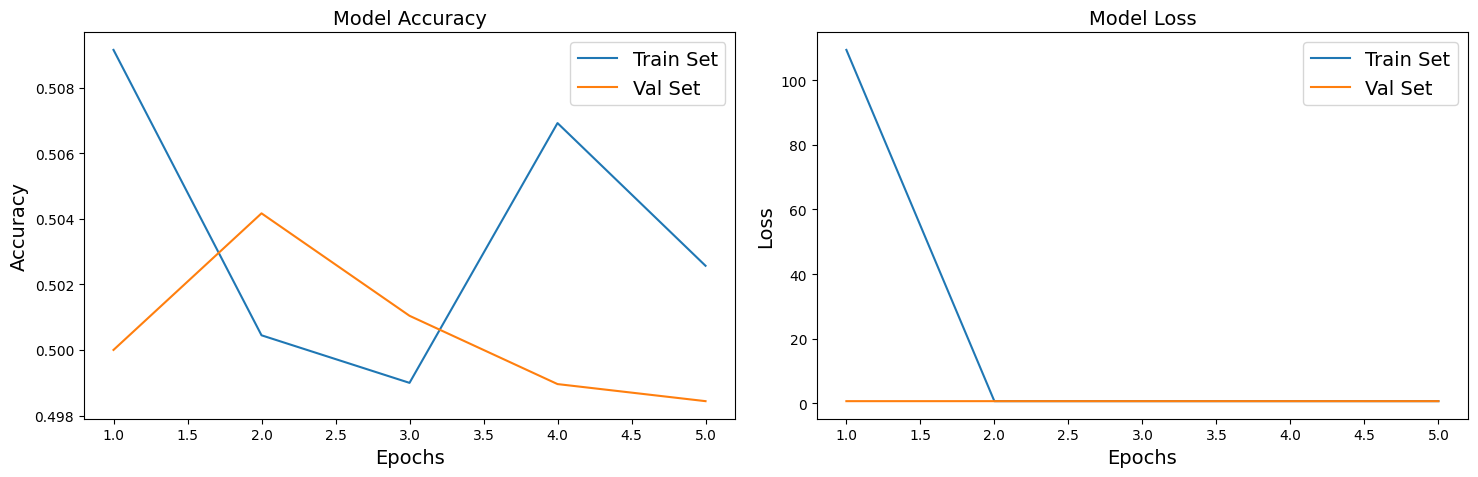

In [22]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()



A baseline score of 50.06% is good to go let's finetune some pretrained model

# Pretrained Models for Transfer Learning

Here i used Xception model for fine-tuning feel free to try the performance of other pretrained models.

All three datasets contain individual images. We need to batch them, but for this we first need to ensure they all have the same size, or else batching will not work. We can use a `Resizing` layer for this. We must also call the `tf.keras.applications.xception.preprocess_input()` function to preprocess the images appropriately for the Xception model. We will also add shuffling and prefetching to the training dataset.

In [23]:
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [24]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

Let's take a look again at the first 9 images from the validation set: they're all with values ranging from -1 to 1:

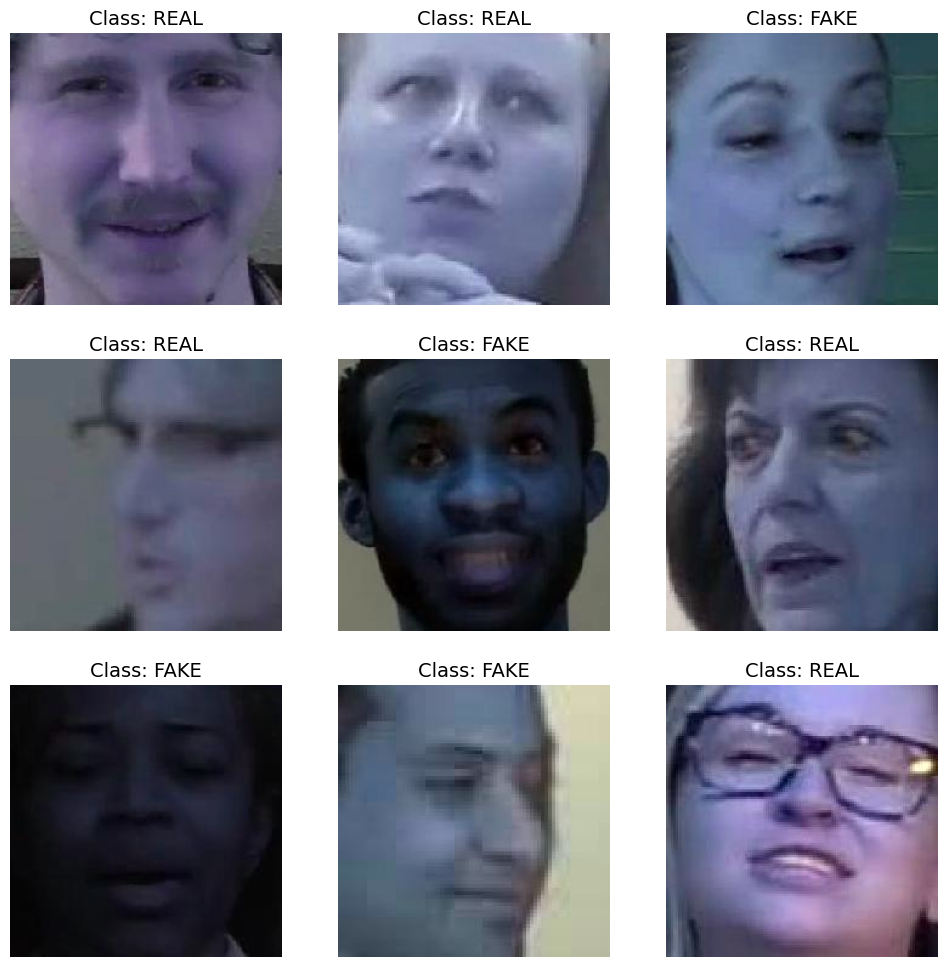

In [25]:
# extra code – displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [26]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

Try running the following cell multiple times to see different random data augmentations:

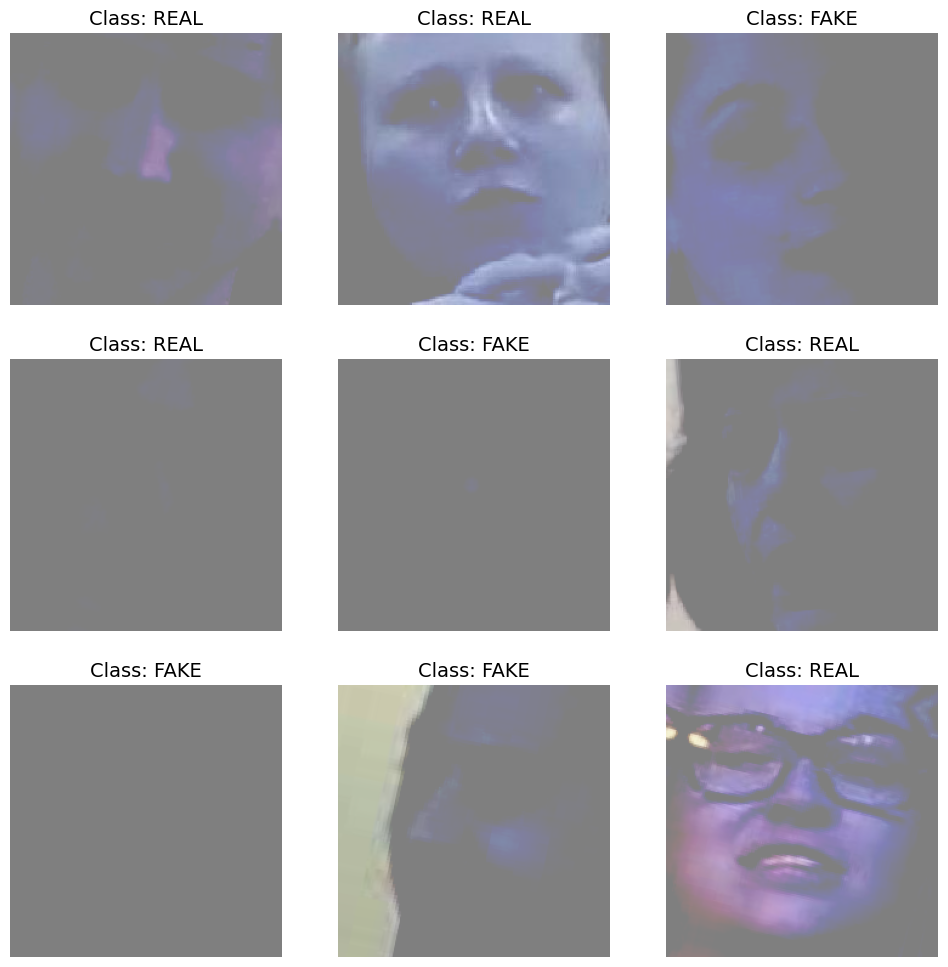

In [27]:
# extra code – displays the same first 9 images, after augmentation

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

Now let's load the pretrained model, without its top layers, and replace them with our own task

In [28]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
for layer in base_model.layers:
    layer.trainable = False

In [30]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.5604 - loss: 0.9047 - val_accuracy: 0.5669 - val_loss: 1.4459
Epoch 2/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - accuracy: 0.6043 - loss: 1.0467 - val_accuracy: 0.6370 - val_loss: 0.7630
Epoch 3/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - accuracy: 0.6244 - loss: 0.9050 - val_accuracy: 0.6141 - val_loss: 0.9378


In [31]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_layer_1          33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [32]:
model.evaluate(test_set)

100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.6315 - loss: 0.9085


[0.9447730183601379, 0.6190624833106995]

In [33]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 70s 186ms/step - accuracy: 0.6286 - loss: 0.6723 - val_accuracy: 0.7432 - val_loss: 0.5180
Epoch 2/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 50s 178ms/step - accuracy: 0.8455 - loss: 0.3455 - val_accuracy: 0.7667 - val_loss: 0.5547
Epoch 3/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 50s 178ms/step - accuracy: 0.9349 - loss: 0.1701 - val_accuracy: 0.7307 - val_loss: 0.7942
Epoch 4/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 50s 178ms/step - accuracy: 0.9557 - loss: 0.1247 - val_accuracy: 0.7820 - val_loss: 0.7406
Epoch 5/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 50s 177ms/step - accuracy: 0.9694 - loss: 0.0848 - val_accuracy: 0.8029 - val_loss: 0.6708
Epoch 6/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 50s 178ms/step - accuracy: 0.9771 - loss: 0.0635 - val_accuracy: 0.8107 - val_loss: 0.7697
Epoch 7/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 50s 178ms/step - accuracy: 0.9837 - loss: 0.0455 - val_accuracy: 0.8135 - val_loss: 0.6918
Epoch 8/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 50s 178ms/step - accuracy: 0.9872 - loss: 0

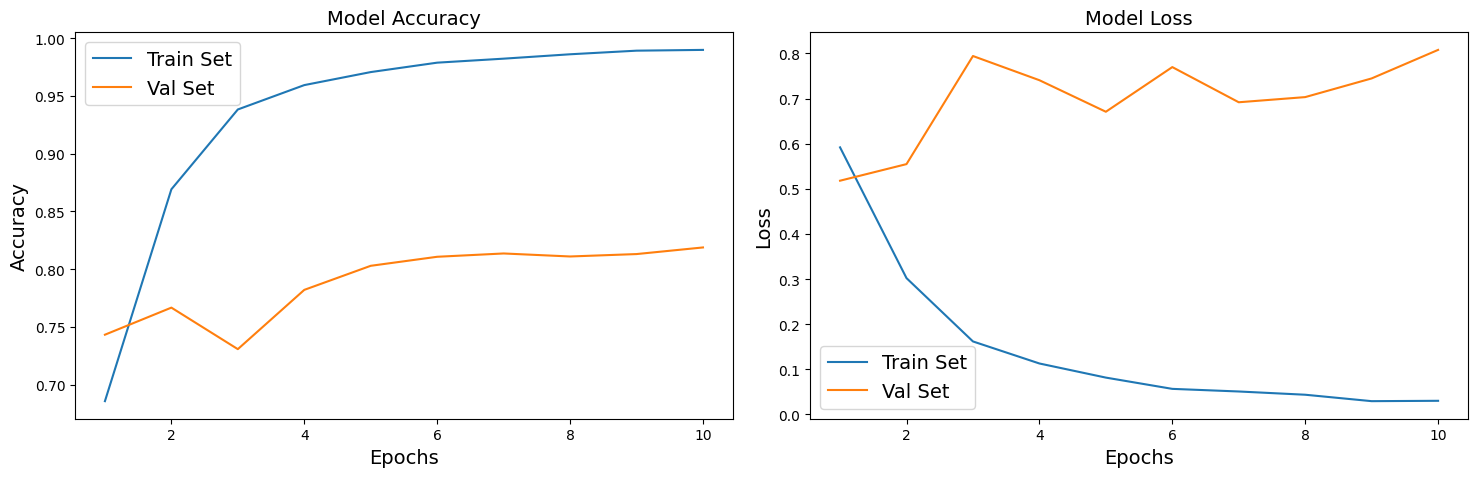

In [34]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [35]:
model.evaluate(test_set)


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.8296 - loss: 0.7173


[0.7202437520027161, 0.8215625286102295]

In [36]:
# Save the model with the .h5 extension
model.save('xception_deepfake_image.h5')


In [37]:
import tensorflow as tf
from functools import partial
import warnings
warnings.filterwarnings("ignore", message="SetPriority unimplemented for this stream", category=FutureWarning)


# Define DefaultConv2D function with partial
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[224, 224, 3]),
    DefaultConv2D(filters=64, kernel_size=7),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=512),
    DefaultConv2D(filters=512),
    DefaultConv2D(filters=512),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=512),
    DefaultConv2D(filters=512),
    DefaultConv2D(filters=512),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=4096, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=4096, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1000, activation="softmax")  # Last layer for ImageNet classification
])

# Load the trained weights
#model.load_weights('/kaggle/working/xception_deepfake_image.h5')
# Load the trained weights
#model.load_weights('/kaggle/working/xception_deepfake_image.h5')


In [38]:
import os

weights_path = '/kaggle/working/xception_deepfake_image.h5'

if os.path.exists(weights_path):
    # Load the trained weights
    try:
        model.load_weights(weights_path)
        print("Weights loaded successfully.")
    except Exception as e:
        print("Error loading weights:", e)
else:
    print(f"Error: The file '{weights_path}' does not exist.")


Error loading weights: Layer count mismatch when loading weights from file. Model expected 15 layers, found 81 saved layers.


In [39]:
import os

image_path = '/kaggle/input/srireal1/sri real.jpg'

if os.path.exists(image_path):
    # Load and preprocess the custom image
    custom_image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    custom_image = tf.keras.preprocessing.image.img_to_array(custom_image)
    custom_image = tf.expand_dims(custom_image, axis=0)
    custom_image = custom_image / 255.0  # Normalize the image data
    
    # Get the model's prediction for the custom image
    prediction = model.predict(custom_image)
    
    # Print prediction result or further processing
    #("Prediction:", prediction)
else:
    print(f"Error: The file '{image_path}' does not exist.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [40]:
# Interpret the model's output
if prediction[0][0] >= 2.0e-9:
    print(prediction[0][0])
    print("The imagee is Real")
else:
    print(prediction[0][0])
    print("The image is fake")

1.7507326e-17
The image is fake


In [41]:
# Load and preprocess the custom image
image_path = '/kaggle/input/srigayaembed/fake image s2.jpg'
custom_image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
custom_image = tf.keras.preprocessing.image.img_to_array(custom_image)
custom_image = tf.expand_dims(custom_image, axis=0)
custom_image = custom_image / 250.0  # Normalize the image data

# Get the model's prediction for the custom image
prediction = model.predict(custom_image)
prediction[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


6.763976e-26

In [42]:
# Interpret the model's output
#0.00000000000005
if prediction[0][0] >= 2.0e-14:
    print(prediction[0][0])
    print("The imagee is Real")
else:
    print(prediction[0][0])
    print("The image is fake")

6.763976e-26
The image is fake
